# Embedded ML Lab - Excercise 2 - Quantization (additional experiments)

Until now, we always used a symmetric min/max scale for quantization of the activations, hence a centered zero point.

We will now do two things to squeeze a little bit more accuracy out of the quantization  
* Firstly, we will loosen our assumption of a symmetric range/zero_point
* Secondly, we will consider "cutting away" parts that are not important for the classification choice


In [9]:
from net import CifarNet
import torch

torch.backends.quantized.engine = 'qnnpack'

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)

import time
import nbimporter 

from exercise_21 import net_time
from exercise_21 import net_acc
from exercise_21 import fuse_conv_bn_weights
from exercise_21 import QCifarNet, QConv2dReLU, QLinear
from exercise_21 import tensor_scale

Files already downloaded and verified


We introduce two changed Modules (`QConv2dreluNSym`, `QLinerNSym`) that besides a scale (like in the last exercise) also have an adjustable zero_point that can be also set through the state_dict.

We use these two Modules in a new Classifier called `QCifarNetSym`  

In [10]:
from torch.nn.quantized.modules.utils import _pair_from_first
import torch.nn as nn
import torch.nn.functional as F

#Both classes now also have a state-dict entry for the zero_point
class QConv2dReLUNSym(QConv2dReLU):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(QConv2dReLUNSym, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.register_buffer('zero_point', torch.tensor(64))

    def forward(self, x):
        return torch.ops.quantized.conv2d_relu(x, self._prepack, self.scale, self.zero_point)

    
class QLinearNSym(QLinear):
    def __init__(self, in_features, out_features):
        super(QLinearNSym, self).__init__(in_features, out_features)
        self.register_buffer('zero_point', torch.tensor(64))
   
    def forward(self, x):
        return torch.ops.quantized.linear(x, self._prepack, self.scale, self.zero_point)
    
    
class QCifarNetNSym(QCifarNet):
    def __init__(self):
        super(QCifarNet, self).__init__()
        
        self.register_buffer("scale", torch.tensor(0.1))

        self.conv1 = QConv2dReLUNSym(3, 16, 3, 1, padding=1)
        self.conv2 = QConv2dReLUNSym(16,16, 3, 1, padding=1)

        self.conv3 = QConv2dReLUNSym(16, 32, 3, 1, padding=1)
        self.conv4 = QConv2dReLUNSym(32, 32, 3, 1, padding=1)

        self.conv5 = QConv2dReLUNSym(32, 64, 3, 1, padding=1)
        self.conv6 = QConv2dReLUNSym(64, 64, 3, 1, padding=1)

        self.fc = QLinearNSym(1024, 10)

Your Task:
   * Copy your class description of `CifarNetCalibration` from the last lab into the next block.
   * Besides the calibration, add execute the function `plot_density` after each operator.
   * Run the calibration batch again (code provided) and inspect the figures. What observation can you make?

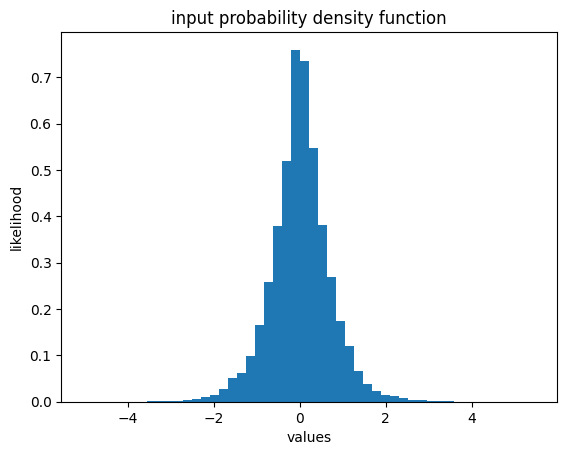

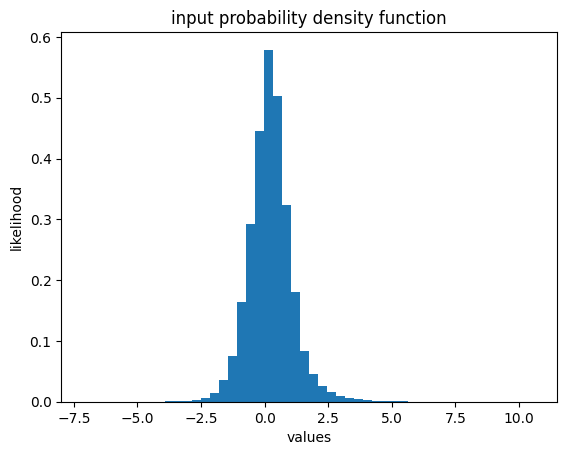

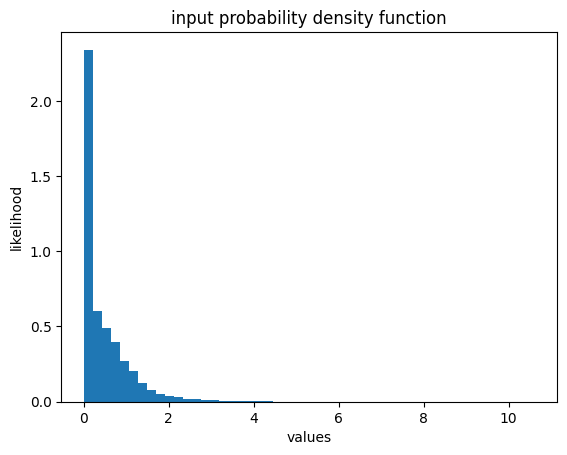

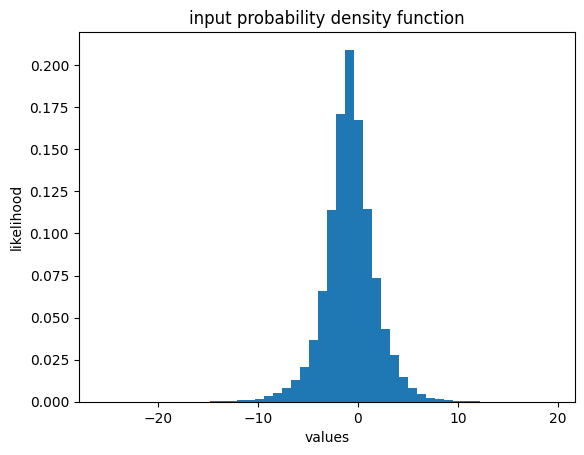

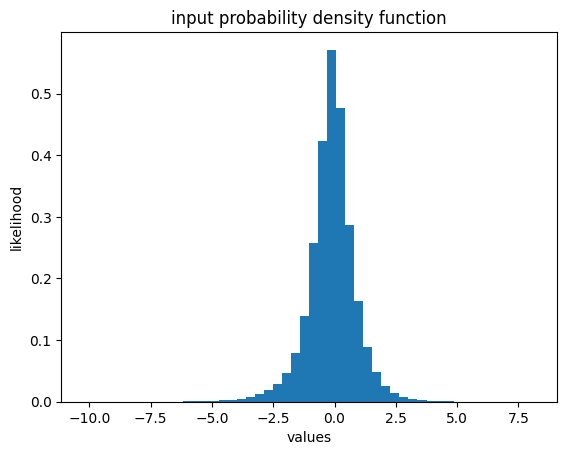

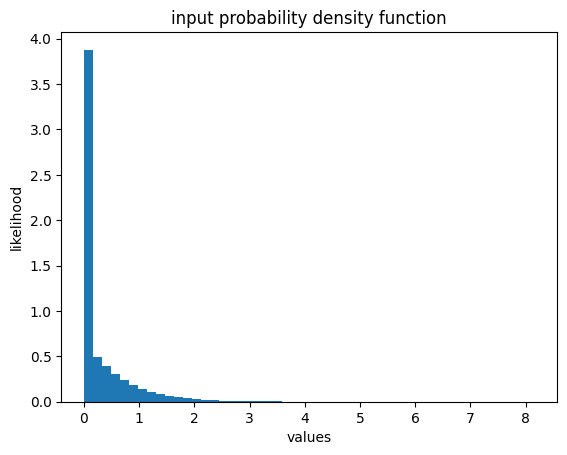

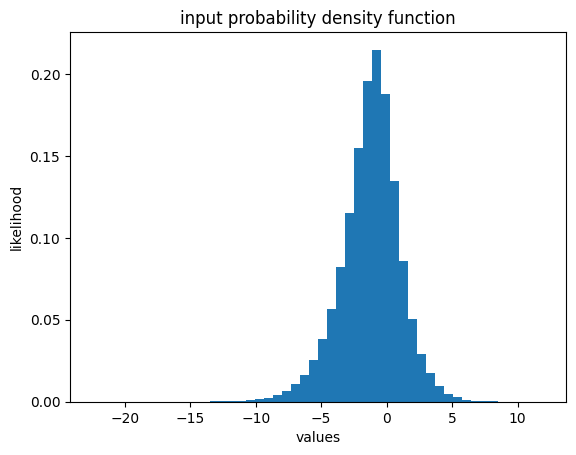

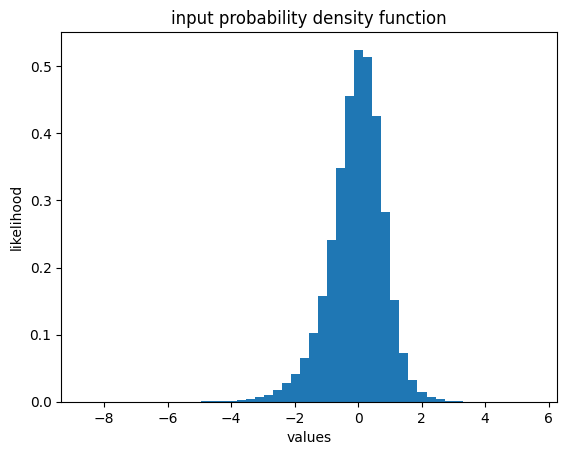

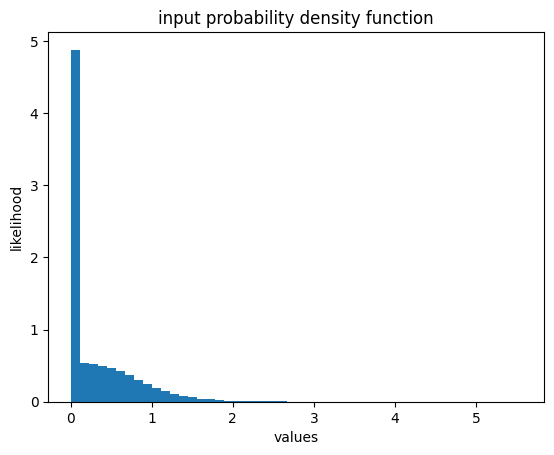

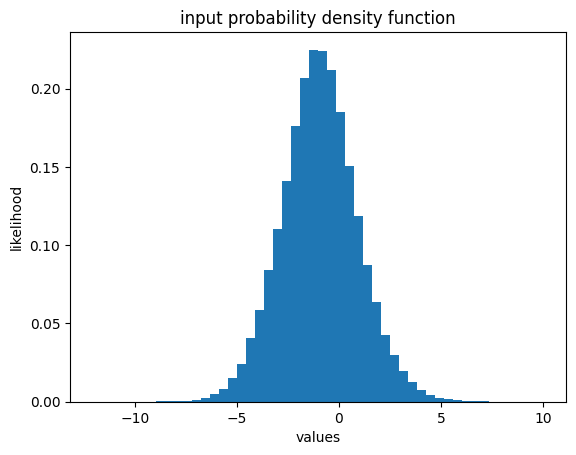

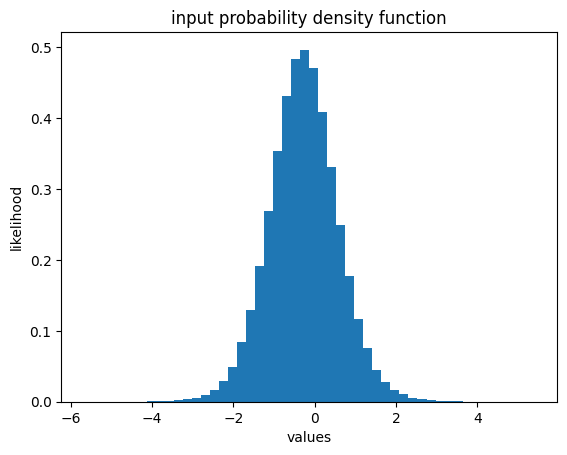

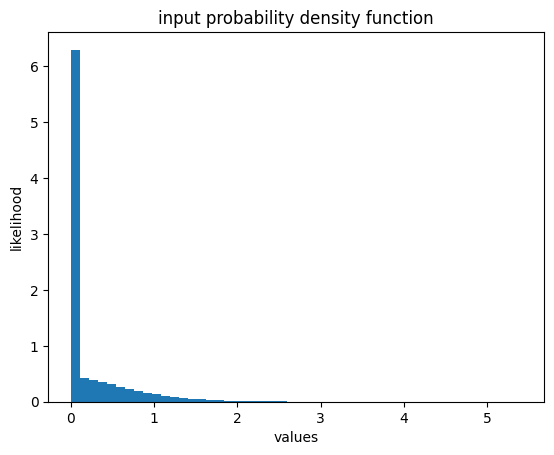

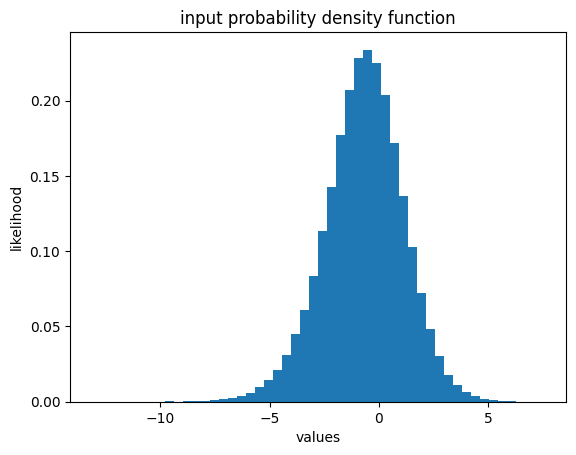

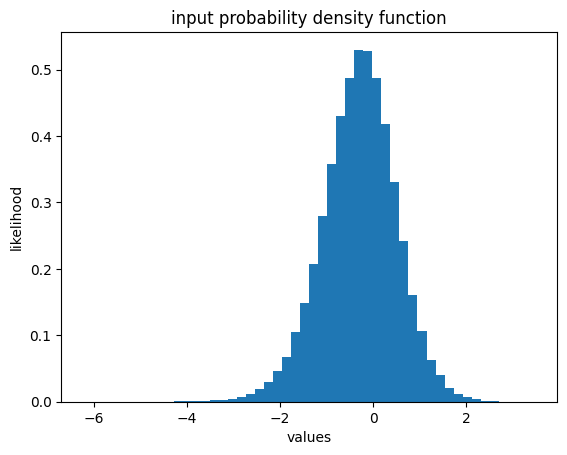

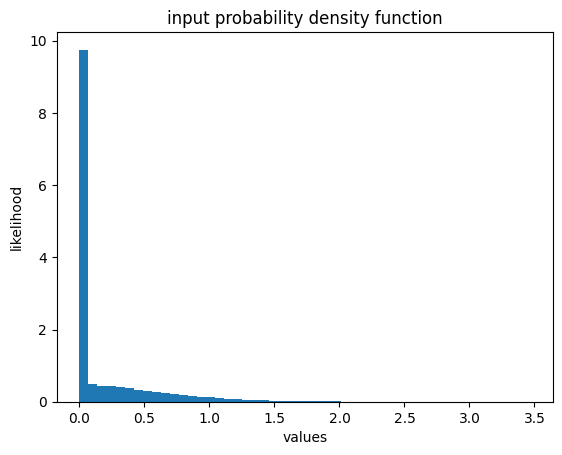

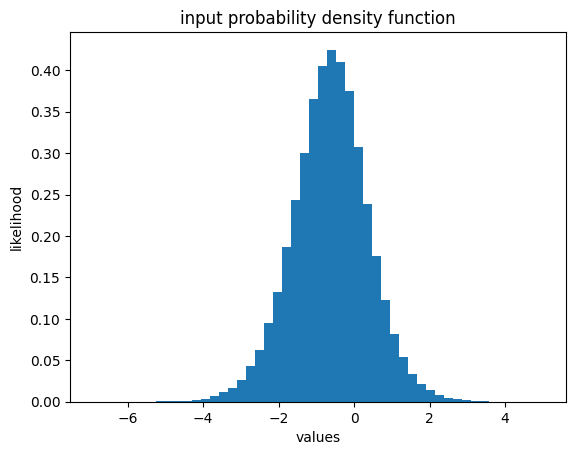

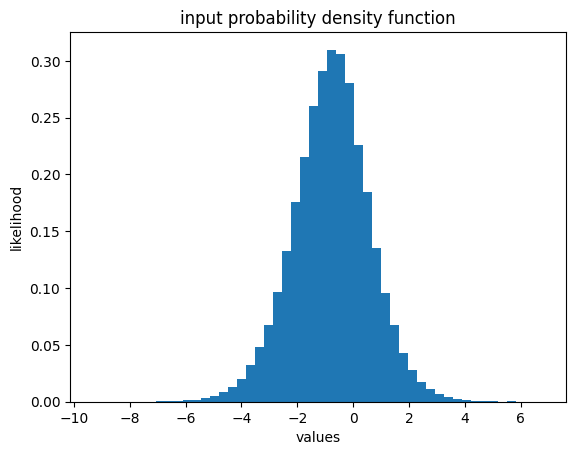

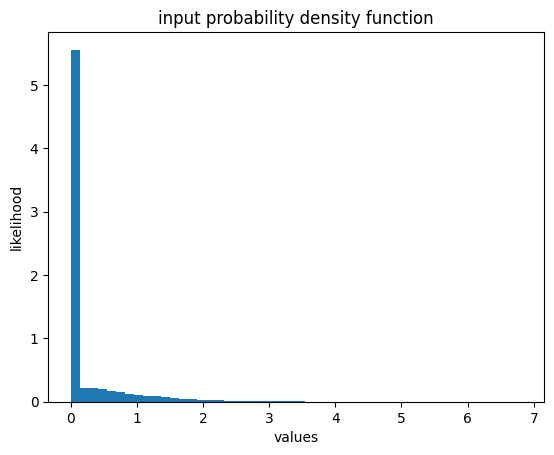

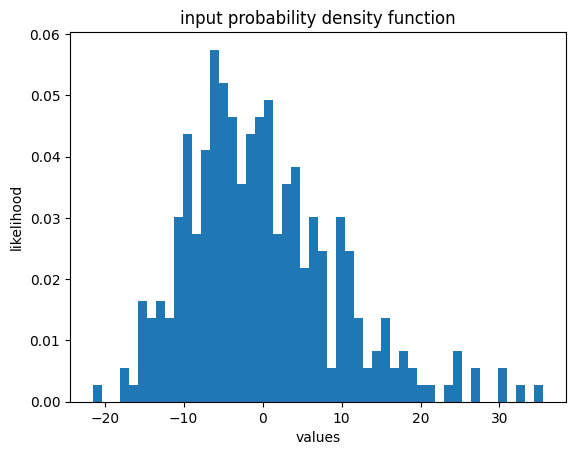

In [11]:
import matplotlib.pyplot as plt

def plot_density(x):
    # input tensor x
    x = x.detach()
    plt.hist(x.flatten().numpy(), range=(float(x.min()),float(x.max())), density=True, bins=50)
    plt.title('input probability density function')
    plt.ylabel('likelihood')
    plt.xlabel('values')
    plt.show()

#--to---be---done---by---student
class CifarNetCalibration(CifarNet):
    def __init__(self):
        super(CifarNetCalibration, self).__init__()
        
        #we add a new dict for the corresponding scales
        self.calibration_dict = {}
        
    def forward(self, x):
        #to-be-done-by-student
        scale = tensor_scale(x)
        self.calibration_dict['scale'] = scale
        
        x = self.conv1(x)
        plot_density(x)
        x = self.bn1(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['conv1.scale'] = scale
        
        x = self.conv2(x)
        plot_density(x)
        x = self.bn2(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['conv2.scale'] = scale
        
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        plot_density(x)
        x = self.bn3(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['conv3.scale'] = scale
        
        x = self.conv4(x)
        plot_density(x)
        x = self.bn4(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['conv4.scale'] = scale
        
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv5(x)
        plot_density(x)
        x = self.bn5(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['conv5.scale'] = scale
        
        x = self.conv6(x)
        plot_density(x)
        x = self.bn6(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['conv6.scale'] = scale
        
        x = F.max_pool2d(x, 2, stride=2)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        plot_density(x)

        scale = tensor_scale(x)
        self.calibration_dict['fc.scale'] = scale
        #--to---be---done---by---student
        return x
#--to---be---done---by---student

#We run the calibration using a batch from the testdata
net_calib = CifarNetCalibration()
net_calib.load_state_dict(torch.load('state_dict.pt'))
_, (data, _) = next(enumerate(testloader))
net_calib(data)
calibration_dict = net_calib.calibration_dict

Your Task: 
* Copy Your code that sets the quantized state dict after calibration from the last lab. The state dict has now new entries `zero_point` for the fused conv and the fc layer.
* Explore what happens if we change the scale of the conv layer in a way that better suits the plots. Use the provided code to determine the accuracy for each step.
* After that, adjust the scale of the conv layers according to the figures

Your Task:
* After that, play around with scale and zero_point of the fully connected layer. What conclusion can we draw?

In [12]:
#prints keys from quantized net
qnet = QCifarNetNSym()
qsd = qnet.state_dict()
for key in qsd: print(key, qsd[key].dtype)

sd = torch.load('state_dict.pt')

###--- COPY YOUR IMPLEMENTATION HERE ---
for idx in range(6):
    qsd['conv{}.scale'.format(idx+1)] = torch.tensor(calibration_dict['conv{}.scale'.format(idx+1)])

qsd['scale'] = torch.tensor(calibration_dict['scale'])
qsd['fc.scale'] = torch.tensor(calibration_dict['fc.scale'])
print("\n\nQuantized CifarNet state dict with scales:")
### ------------------------------------

scale torch.float32
conv1.weight torch.qint8
conv1.bias torch.float32
conv1.scale torch.float32
conv1.zero_point torch.int64
conv2.weight torch.qint8
conv2.bias torch.float32
conv2.scale torch.float32
conv2.zero_point torch.int64
conv3.weight torch.qint8
conv3.bias torch.float32
conv3.scale torch.float32
conv3.zero_point torch.int64
conv4.weight torch.qint8
conv4.bias torch.float32
conv4.scale torch.float32
conv4.zero_point torch.int64
conv5.weight torch.qint8
conv5.bias torch.float32
conv5.scale torch.float32
conv5.zero_point torch.int64
conv6.weight torch.qint8
conv6.bias torch.float32
conv6.scale torch.float32
conv6.zero_point torch.int64
fc.weight torch.qint8
fc.bias torch.float32
fc.scale torch.float32
fc.zero_point torch.int64


Quantized CifarNet state dict with scales:


In [13]:
#We run the accuracy test again to see how much accuracy we loose through quantization
print(f"Accuracy quantized: {net_acc(QCifarNetNSym, qsd, testloader):.4%}")

  6%|██▋                                       | 20/313 [00:02<00:32,  9.07it/s]

Accuracy quantized: 10.4167%
